### Review
- 调参很顺利，一次就过了strong baseline
- 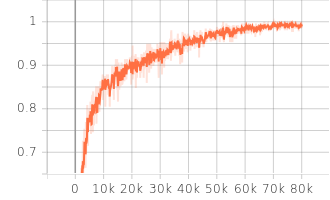
- 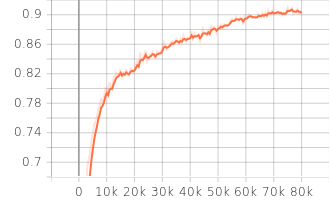
## Tips
- optimizer使用warmup
- 与其自己胡乱写框架，不如学习一些论文中的框架经验，比如应该设几个self-attention层，layer的宽度最好怎么设置，input和output的大小最好呈怎样的关系
- 这次训练时间拉长到了5h，可以看到训练时间不够长的话model的能力就没有充分发挥出来
- tensorboard的使用要注意命令的路径

# Task description
- Classify the speakers of given features.
- Main goal: Learn how to use transformer.
- Baselines:
  - Easy: Run sample code and know how to use transformer.
  - Medium: Know how to adjust parameters of transformer.
  - Hard: Construct [conformer](https://arxiv.org/abs/2005.08100) which is a variety of transformer.

- Other links
  - Kaggle: [link](https://www.kaggle.com/t/859c9ca9ede14fdea841be627c412322)
  - Slide: [link](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW04/HW04.pdf)
  - Data: [link](https://drive.google.com/file/d/1T0RPnu-Sg5eIPwQPfYysipfcz81MnsYe/view?usp=sharing)
  - Video (Chinese): [link](https://www.youtube.com/watch?v=EPerg2UnGaI)
  - Video (English): [link](https://www.youtube.com/watch?v=Gpz6AUvCak0)
  - Solution for downloading dataset fail.: [link](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e?usp=sharing)

# Download dataset
- Please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e?usp=sharing) to download data
- Data is [here](https://drive.google.com/file/d/1gaFy8RaQVUEXo2n0peCBR5gYKCB-mNHc/view?usp=sharing)

In [1]:
!gdown --id 'paste your own data download link' --output Dataset.zip
!unzip Dataset.zip

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok] [--format FORMAT]
             [--user-agent USER_AGENT]
             url_or_id
gdown: error: unrecognized arguments: your own data download link'
'unzip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


# Data

## Dataset
- Original dataset is [Voxceleb1](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/).
- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb1.
- We randomly select 600 speakers from Voxceleb1.
- Then preprocess the raw waveforms into mel-spectrograms.

- Args:
  - data_dir: The path to the data directory.
  - metadata_path: The path to the metadata.
  - segment_len: The length of audio segment for training.
- The architecture of data directory \\
  - data directory \\
  |---- metadata.json \\
  |---- testdata.json \\
  |---- mapping.json \\
  |---- uttr-{random string}.pt \\

- The information in metadata
  - "n_mels": The dimention of mel-spectrogram.
  - "speakers": A dictionary.
    - Key: speaker ids.
    - value: "feature_path" and "mel_len"


For efficiency, we segment the mel-spectrograms into segments in the traing step.

In [2]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence


class myDataset(Dataset):
  def __init__(self, data_dir, segment_len=128):
    self.data_dir = data_dir
    self.segment_len = segment_len

    # Load the mapping from speaker neme to their corresponding id.
    mapping_path = Path(data_dir) / "mapping.json"
    mapping = json.load(mapping_path.open())
    self.speaker2id = mapping["speaker2id"]

    # Load metadata of training data.
    metadata_path = Path(data_dir) / "metadata.json"
    metadata = json.load(open(metadata_path))["speakers"]

    # Get the total number of speaker.
    self.speaker_num = len(metadata.keys())
    self.data = []
    for speaker in metadata.keys():
      for utterances in metadata[speaker]:
        self.data.append([utterances["feature_path"], self.speaker2id[speaker]])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    feat_path, speaker = self.data[index]
    # Load preprocessed mel-spectrogram.
    mel = torch.load(os.path.join(self.data_dir, feat_path))

    # Segmemt mel-spectrogram into "segment_len" frames.
    if len(mel) > self.segment_len:
      # Randomly get the starting point of the segment.
      start = random.randint(0, len(mel) - self.segment_len)
      # Get a segment with "segment_len" frames.
      mel = torch.FloatTensor(mel[start:start+self.segment_len])
    else:
      mel = torch.FloatTensor(mel)
    # Turn the speaker id into long for computing loss later.
    speaker = torch.FloatTensor([speaker]).long()
    return mel, speaker

  def get_speaker_number(self):
    return self.speaker_num

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.


In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
  # Process features within a batch.
  """Collate a batch of data."""
  mel, speaker = zip(*batch)
  # Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
  mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
  # mel: (batch size, length, 40)
  return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size, n_workers):
  """Generate dataloader"""
  dataset = myDataset(data_dir)
  speaker_num = dataset.get_speaker_number()
  # Split dataset into training dataset and validation dataset
  trainlen = int(0.9 * len(dataset))
  print(f"[Info]: Training set length: {trainlen}, Validation set length: {len(dataset) - trainlen}", flush=True)
  lengths = [trainlen, len(dataset) - trainlen]
  trainset, validset = random_split(dataset, lengths)

  train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
  )
  valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_batch,
  )

  return train_loader, valid_loader, speaker_num


# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
  def __init__(self, d_model=128, n_spks=600, dropout=0.1):
    super().__init__()
    # Project the dimension of features from that of input into d_model.
    self.prenet = nn.Sequential(
            nn.Linear(40, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model),
        )
    # TODO:
    #   Change Transformer to Conformer.
    #   https://arxiv.org/abs/2005.08100
    self.encoder_layer = nn.TransformerEncoderLayer(
      d_model=d_model, dim_feedforward=512, nhead=8
    )
    self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=4)

    # Project the the dimension of features from d_model into speaker nums.
    self.pred_layer = nn.Sequential(
      nn.Linear(d_model, d_model),
      nn.BatchNorm1d(d_model),
      nn.Dropout(dropout),
      nn.ReLU(),
      nn.Linear(d_model, n_spks),
    )

  def forward(self, mels):
    """
    args:
      mels: (batch size, length, 40)
    return:
      out: (batch size, n_spks)
    """
    # out: (batch size, length, d_model)
    out = self.prenet(mels)
    # out: (length, batch size, d_model)
    out = out.permute(1, 0, 2)
    # The encoder layer expect features in the shape of (length, batch size, d_model).
    out = self.encoder(out)
    # out: (batch size, length, d_model)
    out = out.transpose(0, 1)
    # mean pooling
    stats = out.mean(dim=1)

    # out: (batch, n_spks)
    out = self.pred_layer(stats)
    return out


# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [5]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
  """
  Create a schedule with a learning rate that decreases following the values of the cosine function between the
  initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
  initial lr set in the optimizer.

  Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule the learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

  Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
  """

  def lr_lambda(current_step):
    # Warmup
    if current_step < num_warmup_steps:
      return float(current_step) / float(max(1, num_warmup_steps))
    # decadence
    progress = float(current_step - num_warmup_steps) / float(
      max(1, num_training_steps - num_warmup_steps)
    )
    return max(
      0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
    )

  return LambdaLR(optimizer, lr_lambda, last_epoch)


# Model Function
- Model forward function.

In [6]:
import torch


def model_fn(batch, model, criterion, device):
  """Forward a batch through the model."""

  mels, labels = batch
  mels = mels.to(device)
  labels = labels.to(device)

  outs = model(mels)

  loss = criterion(outs, labels)

  # Get the speaker id with highest probability.
  preds = outs.argmax(1)
  # Compute accuracy.
  accuracy = torch.mean((preds == labels).float())

  return loss, accuracy


# Validate
- Calculate accuracy of the validation set.

In [7]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device):
  """Validate on validation set."""

  model.eval()
  running_loss = 0.0
  running_accuracy = 0.0
  pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

  for i, batch in enumerate(dataloader):
    with torch.no_grad():
      loss, accuracy = model_fn(batch, model, criterion, device)
      running_loss += loss.item()
      running_accuracy += accuracy.item()

    pbar.update(dataloader.batch_size)
    pbar.set_postfix(
      loss=f"{running_loss / (i+1):.2f}",
      accuracy=f"{running_accuracy / (i+1):.2f}",
    )

  pbar.close()
  model.train()

  return running_accuracy / len(dataloader)


# Main function

In [8]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.multiprocessing as mp
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter


def parse_args():
  """arguments"""
  config = {
    "data_dir": "./Dataset",
    "save_path": "model.ckpt",
    "batch_size": 256,
    "n_workers": 0,
    "valid_steps": 500,
    "warmup_steps": 200,
    "save_steps": 2000,
    "total_steps": 80000,
  }

  return config


def main(
  data_dir,
  save_path,
  batch_size,
  n_workers,
  valid_steps,
  warmup_steps,
  total_steps,
  save_steps,
):
  """Main function."""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"[Info]: Use {device} now!")

  writer = SummaryWriter('runs/ccc')
  writer.add_scalar("test/dummy", 1.0, 0)
  writer.flush()

  train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
  train_iterator = iter(train_loader)
  print(f"[Info]: Finish loading data!",flush = True)

  model = Classifier(n_spks=speaker_num).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=1e-3)
  scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
  print(f"[Info]: Finish creating model!",flush = True)

  best_accuracy = -1.0
  best_state_dict = None

  pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

  for step in range(total_steps):
    # Get data
    try:
      batch = next(train_iterator)
    except StopIteration:
      train_iterator = iter(train_loader)
      batch = next(train_iterator)

    loss, accuracy = model_fn(batch, model, criterion, device)
    batch_loss = loss.item()
    batch_accuracy = accuracy.item()

    # Updata model
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    global_step = step + 1
    writer.add_scalar("train/accuracy", batch_accuracy, global_step)
    writer.flush()

    # Log
    pbar.update()
    pbar.set_postfix(
      loss=f"{batch_loss:.2f}",
      accuracy=f"{batch_accuracy:.2f}",
      step=step + 1,
    )

    # Do validation
    if (step + 1) % valid_steps == 0:
      pbar.close()

      valid_accuracy = valid(valid_loader, model, criterion, device)
      writer.add_scalar("valid/accuracy", valid_accuracy, global_step)
      writer.flush()
      
      # keep the best model
      if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_state_dict = model.state_dict()

      pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    # Save the best model so far.
    if (step + 1) % save_steps == 0 and best_state_dict is not None:
      torch.save(best_state_dict, save_path)
      pbar.write(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

  pbar.close()
  writer.close()


if __name__ == "__main__":
  main(**parse_args())


[Info]: Use cuda now!
[Info]: Training set length: 62494, Validation set length: 6944
[Info]: Finish loading data!


e:\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Info]: Finish creating model!


Train:   0% 0/500 [00:00<?, ? step/s]C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22356\97271689.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mel = torch.load(os.pat

Step 2000, best model saved. (accuracy=0.6188)


Train: 100% 500/500 [02:06<00:00,  3.94 step/s, accuracy=0.75, loss=1.13, step=2500]
Valid: 100% 6912/6944 [00:10<00:00, 665.14 uttr/s, accuracy=0.65, loss=1.46]
Train: 100% 500/500 [02:02<00:00,  4.07 step/s, accuracy=0.70, loss=1.23, step=3000]
Valid: 100% 6912/6944 [00:08<00:00, 804.10 uttr/s, accuracy=0.69, loss=1.29]
Train: 100% 500/500 [02:00<00:00,  4.14 step/s, accuracy=0.73, loss=1.06, step=3500]
Valid: 100% 6912/6944 [00:10<00:00, 669.92 uttr/s, accuracy=0.70, loss=1.24]
Train: 100% 500/500 [02:03<00:00,  4.04 step/s, accuracy=0.76, loss=0.95, step=4000]
Valid: 100% 6912/6944 [00:08<00:00, 791.29 uttr/s, accuracy=0.71, loss=1.20]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 4000, best model saved. (accuracy=0.7121)


Train: 100% 500/500 [02:02<00:00,  4.10 step/s, accuracy=0.72, loss=0.98, step=4500]
Valid: 100% 6912/6944 [00:08<00:00, 777.06 uttr/s, accuracy=0.73, loss=1.13]
Train: 100% 500/500 [02:01<00:00,  4.11 step/s, accuracy=0.73, loss=1.05, step=5000]
Valid: 100% 6912/6944 [00:08<00:00, 803.09 uttr/s, accuracy=0.74, loss=1.09]
Train: 100% 500/500 [01:58<00:00,  4.21 step/s, accuracy=0.75, loss=0.88, step=5500]
Valid: 100% 6912/6944 [00:08<00:00, 795.46 uttr/s, accuracy=0.75, loss=1.04] 
Train: 100% 500/500 [02:00<00:00,  4.16 step/s, accuracy=0.81, loss=0.81, step=6000]
Valid: 100% 6912/6944 [00:08<00:00, 823.15 uttr/s, accuracy=0.76, loss=1.04]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 6000, best model saved. (accuracy=0.7554)


Train: 100% 500/500 [02:03<00:00,  4.03 step/s, accuracy=0.81, loss=0.81, step=6500]
Valid: 100% 6912/6944 [00:07<00:00, 960.93 uttr/s, accuracy=0.76, loss=1.01] 
Train: 100% 500/500 [02:19<00:00,  3.58 step/s, accuracy=0.83, loss=0.63, step=7000]
Valid: 100% 6912/6944 [00:10<00:00, 660.56 uttr/s, accuracy=0.77, loss=0.97]
Train: 100% 500/500 [02:28<00:00,  3.38 step/s, accuracy=0.81, loss=0.67, step=7500]
Valid: 100% 6912/6944 [00:09<00:00, 697.24 uttr/s, accuracy=0.78, loss=0.97]
Train: 100% 500/500 [02:26<00:00,  3.42 step/s, accuracy=0.81, loss=0.66, step=8000]
Valid: 100% 6912/6944 [00:09<00:00, 724.16 uttr/s, accuracy=0.79, loss=0.92]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 8000, best model saved. (accuracy=0.7872)


Train: 100% 500/500 [02:22<00:00,  3.52 step/s, accuracy=0.84, loss=0.71, step=8500]
Valid: 100% 6912/6944 [00:09<00:00, 710.30 uttr/s, accuracy=0.78, loss=0.95]
Train: 100% 500/500 [02:27<00:00,  3.39 step/s, accuracy=0.82, loss=0.71, step=9000]
Valid: 100% 6912/6944 [00:09<00:00, 735.46 uttr/s, accuracy=0.79, loss=0.92]
Train: 100% 500/500 [02:24<00:00,  3.47 step/s, accuracy=0.82, loss=0.65, step=9500]
Valid: 100% 6912/6944 [00:09<00:00, 735.21 uttr/s, accuracy=0.80, loss=0.89]
Train: 100% 500/500 [02:13<00:00,  3.74 step/s, accuracy=0.82, loss=0.70, step=1e+4]
Valid: 100% 6912/6944 [00:08<00:00, 770.64 uttr/s, accuracy=0.80, loss=0.89]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 10000, best model saved. (accuracy=0.8014)


Train: 100% 500/500 [02:17<00:00,  3.64 step/s, accuracy=0.81, loss=0.71, step=10500]
Valid: 100% 6912/6944 [00:09<00:00, 749.43 uttr/s, accuracy=0.79, loss=0.92]
Train: 100% 500/500 [02:18<00:00,  3.62 step/s, accuracy=0.88, loss=0.48, step=11000]
Valid: 100% 6912/6944 [00:10<00:00, 690.75 uttr/s, accuracy=0.81, loss=0.85]
Train: 100% 500/500 [02:17<00:00,  3.63 step/s, accuracy=0.87, loss=0.45, step=11500]
Valid: 100% 6912/6944 [00:09<00:00, 718.12 uttr/s, accuracy=0.80, loss=0.87]
Train: 100% 500/500 [02:21<00:00,  3.54 step/s, accuracy=0.89, loss=0.52, step=12000]
Valid: 100% 6912/6944 [00:10<00:00, 687.36 uttr/s, accuracy=0.80, loss=0.88]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 12000, best model saved. (accuracy=0.8086)


Train: 100% 500/500 [02:07<00:00,  3.91 step/s, accuracy=0.84, loss=0.55, step=12500]
Valid: 100% 6912/6944 [00:09<00:00, 754.95 uttr/s, accuracy=0.82, loss=0.82] 
Train: 100% 500/500 [02:10<00:00,  3.83 step/s, accuracy=0.82, loss=0.64, step=13000]
Valid: 100% 6912/6944 [00:09<00:00, 696.28 uttr/s, accuracy=0.82, loss=0.82]
Train: 100% 500/500 [02:13<00:00,  3.75 step/s, accuracy=0.88, loss=0.50, step=13500]
Valid: 100% 6912/6944 [00:10<00:00, 636.91 uttr/s, accuracy=0.82, loss=0.81]
Train: 100% 500/500 [02:13<00:00,  3.73 step/s, accuracy=0.85, loss=0.54, step=14000]
Valid: 100% 6912/6944 [00:10<00:00, 678.45 uttr/s, accuracy=0.82, loss=0.81]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 14000, best model saved. (accuracy=0.8215)


Train: 100% 500/500 [02:13<00:00,  3.75 step/s, accuracy=0.88, loss=0.43, step=14500]
Valid: 100% 6912/6944 [00:10<00:00, 634.35 uttr/s, accuracy=0.82, loss=0.82]
Train: 100% 500/500 [02:09<00:00,  3.87 step/s, accuracy=0.85, loss=0.40, step=15000]
Valid: 100% 6912/6944 [00:10<00:00, 647.54 uttr/s, accuracy=0.83, loss=0.79]
Train: 100% 500/500 [02:15<00:00,  3.68 step/s, accuracy=0.88, loss=0.40, step=15500]
Valid: 100% 6912/6944 [00:10<00:00, 673.77 uttr/s, accuracy=0.81, loss=0.83]
Train: 100% 500/500 [01:49<00:00,  4.58 step/s, accuracy=0.87, loss=0.46, step=16000]
Valid: 100% 6912/6944 [00:06<00:00, 988.74 uttr/s, accuracy=0.82, loss=0.81] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 16000, best model saved. (accuracy=0.8261)


Train: 100% 500/500 [01:38<00:00,  5.08 step/s, accuracy=0.88, loss=0.40, step=16500]
Valid: 100% 6912/6944 [00:07<00:00, 972.88 uttr/s, accuracy=0.82, loss=0.84] 
Train: 100% 500/500 [01:38<00:00,  5.05 step/s, accuracy=0.91, loss=0.37, step=17000]
Valid: 100% 6912/6944 [00:07<00:00, 979.49 uttr/s, accuracy=0.83, loss=0.80] 
Train: 100% 500/500 [01:39<00:00,  5.05 step/s, accuracy=0.89, loss=0.41, step=17500]
Valid: 100% 6912/6944 [00:07<00:00, 976.38 uttr/s, accuracy=0.82, loss=0.83] 
Train: 100% 500/500 [01:38<00:00,  5.09 step/s, accuracy=0.88, loss=0.37, step=18000]
Valid: 100% 6912/6944 [00:07<00:00, 979.14 uttr/s, accuracy=0.82, loss=0.83] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 18000, best model saved. (accuracy=0.8264)


Train: 100% 500/500 [01:38<00:00,  5.09 step/s, accuracy=0.89, loss=0.37, step=18500]
Valid: 100% 6912/6944 [00:07<00:00, 969.95 uttr/s, accuracy=0.83, loss=0.80] 
Train: 100% 500/500 [01:39<00:00,  5.04 step/s, accuracy=0.89, loss=0.37, step=19000]
Valid: 100% 6912/6944 [00:07<00:00, 969.43 uttr/s, accuracy=0.83, loss=0.81] 
Train: 100% 500/500 [01:37<00:00,  5.12 step/s, accuracy=0.89, loss=0.40, step=19500]
Valid: 100% 6912/6944 [00:07<00:00, 957.10 uttr/s, accuracy=0.82, loss=0.79] 
Train: 100% 500/500 [01:37<00:00,  5.14 step/s, accuracy=0.91, loss=0.37, step=2e+4] 
Valid: 100% 6912/6944 [00:07<00:00, 939.75 uttr/s, accuracy=0.83, loss=0.81] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 20000, best model saved. (accuracy=0.8267)


Train: 100% 500/500 [01:38<00:00,  5.06 step/s, accuracy=0.91, loss=0.34, step=20500]
Valid: 100% 6912/6944 [00:07<00:00, 956.55 uttr/s, accuracy=0.83, loss=0.79] 
Train: 100% 500/500 [01:37<00:00,  5.15 step/s, accuracy=0.89, loss=0.36, step=21000]
Valid: 100% 6912/6944 [00:07<00:00, 970.35 uttr/s, accuracy=0.84, loss=0.76] 
Train: 100% 500/500 [01:35<00:00,  5.22 step/s, accuracy=0.86, loss=0.49, step=21500]
Valid: 100% 6912/6944 [00:07<00:00, 945.39 uttr/s, accuracy=0.83, loss=0.80] 
Train: 100% 500/500 [01:35<00:00,  5.22 step/s, accuracy=0.93, loss=0.23, step=22000]
Valid: 100% 6912/6944 [00:07<00:00, 936.20 uttr/s, accuracy=0.85, loss=0.71] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 22000, best model saved. (accuracy=0.8487)


Train: 100% 500/500 [01:35<00:00,  5.24 step/s, accuracy=0.93, loss=0.30, step=22500]
Valid: 100% 6912/6944 [00:07<00:00, 968.93 uttr/s, accuracy=0.84, loss=0.73] 
Train: 100% 500/500 [01:34<00:00,  5.28 step/s, accuracy=0.91, loss=0.39, step=23000]
Valid: 100% 6912/6944 [00:07<00:00, 957.45 uttr/s, accuracy=0.84, loss=0.75] 
Train: 100% 500/500 [01:35<00:00,  5.24 step/s, accuracy=0.93, loss=0.31, step=23500]
Valid: 100% 6912/6944 [00:07<00:00, 929.32 uttr/s, accuracy=0.85, loss=0.75] 
Train: 100% 500/500 [01:36<00:00,  5.18 step/s, accuracy=0.90, loss=0.31, step=24000]
Valid: 100% 6912/6944 [00:07<00:00, 966.68 uttr/s, accuracy=0.85, loss=0.73] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 24000, best model saved. (accuracy=0.8516)


Train: 100% 500/500 [01:34<00:00,  5.28 step/s, accuracy=0.90, loss=0.28, step=24500]
Valid: 100% 6912/6944 [00:07<00:00, 963.77 uttr/s, accuracy=0.84, loss=0.78] 
Train: 100% 500/500 [01:33<00:00,  5.33 step/s, accuracy=0.90, loss=0.34, step=25000]
Valid: 100% 6912/6944 [00:06<00:00, 1011.06 uttr/s, accuracy=0.84, loss=0.77]
Train: 100% 500/500 [01:35<00:00,  5.25 step/s, accuracy=0.93, loss=0.26, step=25500]
Valid: 100% 6912/6944 [00:07<00:00, 970.66 uttr/s, accuracy=0.85, loss=0.75] 
Train: 100% 500/500 [01:36<00:00,  5.16 step/s, accuracy=0.91, loss=0.35, step=26000]
Valid: 100% 6912/6944 [00:07<00:00, 985.82 uttr/s, accuracy=0.85, loss=0.73] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 26000, best model saved. (accuracy=0.8516)


Train: 100% 500/500 [01:37<00:00,  5.14 step/s, accuracy=0.93, loss=0.28, step=26500]
Valid: 100% 6912/6944 [00:08<00:00, 838.93 uttr/s, accuracy=0.85, loss=0.76] 
Train: 100% 500/500 [02:03<00:00,  4.05 step/s, accuracy=0.91, loss=0.29, step=27000]
Valid: 100% 6912/6944 [00:09<00:00, 733.37 uttr/s, accuracy=0.85, loss=0.77]
Train: 100% 500/500 [02:05<00:00,  3.97 step/s, accuracy=0.93, loss=0.21, step=27500]
Valid: 100% 6912/6944 [00:08<00:00, 778.75 uttr/s, accuracy=0.84, loss=0.79]
Train: 100% 500/500 [02:03<00:00,  4.05 step/s, accuracy=0.94, loss=0.22, step=28000]
Valid: 100% 6912/6944 [00:08<00:00, 776.83 uttr/s, accuracy=0.85, loss=0.77]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 28000, best model saved. (accuracy=0.8516)


Train: 100% 500/500 [02:01<00:00,  4.13 step/s, accuracy=0.91, loss=0.30, step=28500]
Valid: 100% 6912/6944 [00:08<00:00, 778.54 uttr/s, accuracy=0.85, loss=0.75]
Train: 100% 500/500 [01:58<00:00,  4.20 step/s, accuracy=0.92, loss=0.28, step=29000]
Valid: 100% 6912/6944 [00:08<00:00, 781.90 uttr/s, accuracy=0.85, loss=0.75]
Train: 100% 500/500 [02:00<00:00,  4.14 step/s, accuracy=0.90, loss=0.33, step=29500]
Valid: 100% 6912/6944 [00:08<00:00, 799.79 uttr/s, accuracy=0.85, loss=0.73]
Train: 100% 500/500 [02:00<00:00,  4.16 step/s, accuracy=0.93, loss=0.22, step=3e+4] 
Valid: 100% 6912/6944 [00:08<00:00, 819.97 uttr/s, accuracy=0.86, loss=0.72] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 30000, best model saved. (accuracy=0.8552)


Train: 100% 500/500 [02:00<00:00,  4.15 step/s, accuracy=0.93, loss=0.20, step=30500]
Valid: 100% 6912/6944 [00:08<00:00, 798.77 uttr/s, accuracy=0.86, loss=0.68]
Train: 100% 500/500 [01:56<00:00,  4.28 step/s, accuracy=0.90, loss=0.34, step=31000]
Valid: 100% 6912/6944 [00:08<00:00, 805.03 uttr/s, accuracy=0.86, loss=0.71]
Train: 100% 500/500 [01:58<00:00,  4.21 step/s, accuracy=0.94, loss=0.17, step=31500]
Valid: 100% 6912/6944 [00:08<00:00, 806.92 uttr/s, accuracy=0.85, loss=0.72]
Train: 100% 500/500 [01:58<00:00,  4.23 step/s, accuracy=0.95, loss=0.19, step=32000]
Valid: 100% 6912/6944 [00:09<00:00, 751.16 uttr/s, accuracy=0.86, loss=0.73]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 32000, best model saved. (accuracy=0.8630)


Train: 100% 500/500 [01:34<00:00,  5.28 step/s, accuracy=0.93, loss=0.28, step=32500]
Valid: 100% 6912/6944 [00:06<00:00, 1000.65 uttr/s, accuracy=0.86, loss=0.72]
Train: 100% 500/500 [01:35<00:00,  5.26 step/s, accuracy=0.92, loss=0.24, step=33000]
Valid: 100% 6912/6944 [00:06<00:00, 998.52 uttr/s, accuracy=0.86, loss=0.72] 
Train: 100% 500/500 [01:35<00:00,  5.25 step/s, accuracy=0.97, loss=0.13, step=33500]
Valid: 100% 6912/6944 [00:06<00:00, 990.23 uttr/s, accuracy=0.86, loss=0.69] 
Train: 100% 500/500 [01:35<00:00,  5.23 step/s, accuracy=0.93, loss=0.27, step=34000]
Valid: 100% 6912/6944 [00:07<00:00, 900.25 uttr/s, accuracy=0.86, loss=0.75] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 34000, best model saved. (accuracy=0.8640)


Train: 100% 500/500 [01:58<00:00,  4.21 step/s, accuracy=0.96, loss=0.12, step=34500]
Valid: 100% 6912/6944 [00:08<00:00, 784.44 uttr/s, accuracy=0.86, loss=0.67]
Train: 100% 500/500 [01:56<00:00,  4.31 step/s, accuracy=0.93, loss=0.22, step=35000]
Valid: 100% 6912/6944 [00:07<00:00, 898.41 uttr/s, accuracy=0.87, loss=0.67] 
Train: 100% 500/500 [01:59<00:00,  4.18 step/s, accuracy=0.95, loss=0.19, step=35500]
Valid: 100% 6912/6944 [00:09<00:00, 763.32 uttr/s, accuracy=0.86, loss=0.71]
Train: 100% 500/500 [01:57<00:00,  4.24 step/s, accuracy=0.93, loss=0.20, step=36000]
Valid: 100% 6912/6944 [00:08<00:00, 772.11 uttr/s, accuracy=0.86, loss=0.70]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 36000, best model saved. (accuracy=0.8675)


Train: 100% 500/500 [01:56<00:00,  4.30 step/s, accuracy=0.92, loss=0.27, step=36500]
Valid: 100% 6912/6944 [00:08<00:00, 806.61 uttr/s, accuracy=0.87, loss=0.68]
Train: 100% 500/500 [01:56<00:00,  4.29 step/s, accuracy=0.93, loss=0.24, step=37000]
Valid: 100% 6912/6944 [00:08<00:00, 791.28 uttr/s, accuracy=0.86, loss=0.70]
Train: 100% 500/500 [01:57<00:00,  4.25 step/s, accuracy=0.96, loss=0.13, step=37500]
Valid: 100% 6912/6944 [00:08<00:00, 802.38 uttr/s, accuracy=0.87, loss=0.69]
Train: 100% 500/500 [01:57<00:00,  4.27 step/s, accuracy=0.95, loss=0.17, step=38000]
Valid: 100% 6912/6944 [00:08<00:00, 797.41 uttr/s, accuracy=0.87, loss=0.68]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 38000, best model saved. (accuracy=0.8715)


Train: 100% 500/500 [01:57<00:00,  4.25 step/s, accuracy=0.95, loss=0.18, step=38500]
Valid: 100% 6912/6944 [00:08<00:00, 794.66 uttr/s, accuracy=0.86, loss=0.70]
Train: 100% 500/500 [01:37<00:00,  5.13 step/s, accuracy=0.95, loss=0.20, step=39000]
Valid: 100% 6912/6944 [00:07<00:00, 948.92 uttr/s, accuracy=0.87, loss=0.69] 
Train: 100% 500/500 [01:36<00:00,  5.17 step/s, accuracy=0.93, loss=0.24, step=39500]
Valid: 100% 6912/6944 [00:07<00:00, 935.05 uttr/s, accuracy=0.87, loss=0.71] 
Train: 100% 500/500 [01:36<00:00,  5.16 step/s, accuracy=0.95, loss=0.19, step=4e+4] 
Valid: 100% 6912/6944 [00:07<00:00, 959.84 uttr/s, accuracy=0.87, loss=0.68] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 40000, best model saved. (accuracy=0.8715)


Train: 100% 500/500 [01:32<00:00,  5.39 step/s, accuracy=0.96, loss=0.10, step=40500]
Valid: 100% 6912/6944 [00:07<00:00, 968.06 uttr/s, accuracy=0.88, loss=0.65] 
Train: 100% 500/500 [01:44<00:00,  4.79 step/s, accuracy=0.93, loss=0.23, step=41000]
Valid: 100% 6912/6944 [00:08<00:00, 778.38 uttr/s, accuracy=0.86, loss=0.73]
Train: 100% 500/500 [01:36<00:00,  5.17 step/s, accuracy=0.97, loss=0.12, step=41500]
Valid: 100% 6912/6944 [00:07<00:00, 964.24 uttr/s, accuracy=0.87, loss=0.65] 
Train: 100% 500/500 [01:34<00:00,  5.30 step/s, accuracy=0.96, loss=0.19, step=42000]
Valid: 100% 6912/6944 [00:07<00:00, 962.02 uttr/s, accuracy=0.87, loss=0.68] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 42000, best model saved. (accuracy=0.8777)


Train: 100% 500/500 [01:55<00:00,  4.31 step/s, accuracy=0.96, loss=0.10, step=42500]
Valid: 100% 6912/6944 [00:09<00:00, 727.93 uttr/s, accuracy=0.87, loss=0.67]
Train: 100% 500/500 [01:58<00:00,  4.22 step/s, accuracy=0.97, loss=0.13, step=43000]
Valid: 100% 6912/6944 [00:08<00:00, 777.33 uttr/s, accuracy=0.87, loss=0.67]
Train: 100% 500/500 [01:58<00:00,  4.21 step/s, accuracy=0.96, loss=0.13, step=43500]
Valid: 100% 6912/6944 [00:09<00:00, 711.30 uttr/s, accuracy=0.86, loss=0.72]
Train: 100% 500/500 [01:57<00:00,  4.24 step/s, accuracy=0.96, loss=0.12, step=44000]
Valid: 100% 6912/6944 [00:08<00:00, 772.64 uttr/s, accuracy=0.87, loss=0.68]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 44000, best model saved. (accuracy=0.8777)


Train: 100% 500/500 [01:56<00:00,  4.29 step/s, accuracy=0.98, loss=0.10, step=44500]
Valid: 100% 6912/6944 [00:08<00:00, 785.89 uttr/s, accuracy=0.88, loss=0.65]
Train: 100% 500/500 [01:47<00:00,  4.67 step/s, accuracy=0.96, loss=0.13, step=45000]
Valid: 100% 6912/6944 [00:07<00:00, 983.33 uttr/s, accuracy=0.88, loss=0.64] 
Train: 100% 500/500 [01:34<00:00,  5.32 step/s, accuracy=0.98, loss=0.07, step=45500]
Valid: 100% 6912/6944 [00:07<00:00, 986.98 uttr/s, accuracy=0.87, loss=0.68] 
Train: 100% 500/500 [01:33<00:00,  5.34 step/s, accuracy=0.96, loss=0.11, step=46000]
Valid: 100% 6912/6944 [00:06<00:00, 988.08 uttr/s, accuracy=0.87, loss=0.69] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 46000, best model saved. (accuracy=0.8809)


Train: 100% 500/500 [01:32<00:00,  5.40 step/s, accuracy=0.96, loss=0.12, step=46500]
Valid: 100% 6912/6944 [00:06<00:00, 998.82 uttr/s, accuracy=0.88, loss=0.66] 
Train: 100% 500/500 [01:34<00:00,  5.30 step/s, accuracy=0.96, loss=0.13, step=47000]
Valid: 100% 6912/6944 [00:07<00:00, 974.64 uttr/s, accuracy=0.87, loss=0.68] 
Train: 100% 500/500 [01:56<00:00,  4.30 step/s, accuracy=0.97, loss=0.10, step=47500]
Valid: 100% 6912/6944 [00:08<00:00, 791.87 uttr/s, accuracy=0.89, loss=0.63]
Train: 100% 500/500 [01:56<00:00,  4.31 step/s, accuracy=0.98, loss=0.07, step=48000]
Valid: 100% 6912/6944 [00:09<00:00, 745.03 uttr/s, accuracy=0.88, loss=0.65]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 48000, best model saved. (accuracy=0.8863)


Train: 100% 500/500 [01:36<00:00,  5.17 step/s, accuracy=0.98, loss=0.07, step=48500]
Valid: 100% 6912/6944 [00:06<00:00, 999.64 uttr/s, accuracy=0.88, loss=0.65] 
Train: 100% 500/500 [01:38<00:00,  5.05 step/s, accuracy=0.98, loss=0.06, step=49000]
Valid: 100% 6912/6944 [00:09<00:00, 759.55 uttr/s, accuracy=0.88, loss=0.65]
Train: 100% 500/500 [01:45<00:00,  4.72 step/s, accuracy=0.97, loss=0.09, step=49500]
Valid: 100% 6912/6944 [00:07<00:00, 980.87 uttr/s, accuracy=0.87, loss=0.66] 
Train: 100% 500/500 [01:36<00:00,  5.20 step/s, accuracy=0.98, loss=0.10, step=5e+4] 
Valid: 100% 6912/6944 [00:06<00:00, 995.53 uttr/s, accuracy=0.88, loss=0.64] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 50000, best model saved. (accuracy=0.8863)


Train: 100% 500/500 [01:35<00:00,  5.22 step/s, accuracy=0.96, loss=0.11, step=50500]
Valid: 100% 6912/6944 [00:06<00:00, 988.51 uttr/s, accuracy=0.88, loss=0.66] 
Train: 100% 500/500 [01:35<00:00,  5.23 step/s, accuracy=0.97, loss=0.07, step=51000]
Valid: 100% 6912/6944 [00:07<00:00, 980.58 uttr/s, accuracy=0.89, loss=0.64] 
Train: 100% 500/500 [01:40<00:00,  4.97 step/s, accuracy=0.96, loss=0.09, step=51500]
Valid: 100% 6912/6944 [00:07<00:00, 965.80 uttr/s, accuracy=0.88, loss=0.67] 
Train: 100% 500/500 [01:40<00:00,  5.00 step/s, accuracy=0.97, loss=0.10, step=52000]
Valid: 100% 6912/6944 [00:07<00:00, 954.31 uttr/s, accuracy=0.89, loss=0.63] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 52000, best model saved. (accuracy=0.8869)


Train: 100% 500/500 [01:40<00:00,  4.99 step/s, accuracy=0.98, loss=0.09, step=52500]
Valid: 100% 6912/6944 [00:07<00:00, 920.33 uttr/s, accuracy=0.89, loss=0.62]
Train: 100% 500/500 [01:43<00:00,  4.82 step/s, accuracy=0.99, loss=0.05, step=53000]
Valid: 100% 6912/6944 [00:07<00:00, 909.05 uttr/s, accuracy=0.89, loss=0.61] 
Train: 100% 500/500 [01:41<00:00,  4.92 step/s, accuracy=0.99, loss=0.05, step=53500]
Valid: 100% 6912/6944 [00:07<00:00, 944.76 uttr/s, accuracy=0.89, loss=0.62] 
Train: 100% 500/500 [01:41<00:00,  4.94 step/s, accuracy=0.99, loss=0.06, step=54000]
Valid: 100% 6912/6944 [00:07<00:00, 919.97 uttr/s, accuracy=0.89, loss=0.61] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 54000, best model saved. (accuracy=0.8886)


Train: 100% 500/500 [01:44<00:00,  4.77 step/s, accuracy=0.97, loss=0.06, step=54500]
Valid: 100% 6912/6944 [00:08<00:00, 790.13 uttr/s, accuracy=0.89, loss=0.59]
Train: 100% 500/500 [01:43<00:00,  4.83 step/s, accuracy=0.97, loss=0.11, step=55000]
Valid: 100% 6912/6944 [00:07<00:00, 906.15 uttr/s, accuracy=0.89, loss=0.60] 
Train: 100% 500/500 [01:44<00:00,  4.77 step/s, accuracy=0.98, loss=0.05, step=55500]
Valid: 100% 6912/6944 [00:07<00:00, 979.74 uttr/s, accuracy=0.89, loss=0.63] 
Train: 100% 500/500 [01:42<00:00,  4.86 step/s, accuracy=0.98, loss=0.10, step=56000]
Valid: 100% 6912/6944 [00:07<00:00, 954.43 uttr/s, accuracy=0.89, loss=0.60] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 56000, best model saved. (accuracy=0.8947)


Train: 100% 500/500 [01:41<00:00,  4.92 step/s, accuracy=0.98, loss=0.07, step=56500]
Valid: 100% 6912/6944 [00:07<00:00, 962.17 uttr/s, accuracy=0.90, loss=0.58] 
Train: 100% 500/500 [01:42<00:00,  4.89 step/s, accuracy=0.99, loss=0.05, step=57000]
Valid: 100% 6912/6944 [00:07<00:00, 976.68 uttr/s, accuracy=0.89, loss=0.61] 
Train: 100% 500/500 [01:55<00:00,  4.32 step/s, accuracy=0.99, loss=0.03, step=57500]
Valid: 100% 6912/6944 [00:09<00:00, 735.91 uttr/s, accuracy=0.89, loss=0.63]
Train: 100% 500/500 [02:00<00:00,  4.15 step/s, accuracy=0.98, loss=0.05, step=58000]
Valid: 100% 6912/6944 [00:08<00:00, 793.09 uttr/s, accuracy=0.90, loss=0.58]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 58000, best model saved. (accuracy=0.8971)


Train: 100% 500/500 [01:59<00:00,  4.19 step/s, accuracy=0.99, loss=0.03, step=58500]
Valid: 100% 6912/6944 [00:11<00:00, 620.96 uttr/s, accuracy=0.89, loss=0.58]
Train: 100% 500/500 [02:14<00:00,  3.72 step/s, accuracy=0.98, loss=0.07, step=59000]
Valid: 100% 6912/6944 [00:10<00:00, 668.85 uttr/s, accuracy=0.89, loss=0.65]
Train: 100% 500/500 [02:13<00:00,  3.76 step/s, accuracy=0.98, loss=0.06, step=59500]
Valid: 100% 6912/6944 [00:10<00:00, 664.30 uttr/s, accuracy=0.90, loss=0.59]
Train: 100% 500/500 [02:09<00:00,  3.87 step/s, accuracy=0.98, loss=0.04, step=6e+4] 
Valid: 100% 6912/6944 [00:10<00:00, 643.85 uttr/s, accuracy=0.90, loss=0.59]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 60000, best model saved. (accuracy=0.8980)


Train: 100% 500/500 [02:13<00:00,  3.75 step/s, accuracy=0.96, loss=0.12, step=60500]
Valid: 100% 6912/6944 [00:10<00:00, 684.57 uttr/s, accuracy=0.90, loss=0.58]
Train: 100% 500/500 [02:12<00:00,  3.76 step/s, accuracy=0.99, loss=0.03, step=61000]
Valid: 100% 6912/6944 [00:10<00:00, 666.30 uttr/s, accuracy=0.90, loss=0.60]
Train: 100% 500/500 [02:10<00:00,  3.83 step/s, accuracy=0.99, loss=0.06, step=61500]
Valid: 100% 6912/6944 [00:10<00:00, 689.98 uttr/s, accuracy=0.90, loss=0.57]
Train: 100% 500/500 [02:09<00:00,  3.85 step/s, accuracy=0.99, loss=0.04, step=62000]
Valid: 100% 6912/6944 [00:10<00:00, 669.94 uttr/s, accuracy=0.90, loss=0.64]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 62000, best model saved. (accuracy=0.9003)


Train: 100% 500/500 [02:13<00:00,  3.76 step/s, accuracy=1.00, loss=0.02, step=62500]
Valid: 100% 6912/6944 [00:08<00:00, 804.24 uttr/s, accuracy=0.90, loss=0.61]
Train: 100% 500/500 [02:07<00:00,  3.91 step/s, accuracy=0.98, loss=0.04, step=63000]
Valid: 100% 6912/6944 [00:09<00:00, 715.05 uttr/s, accuracy=0.90, loss=0.60]
Train: 100% 500/500 [02:11<00:00,  3.79 step/s, accuracy=0.98, loss=0.04, step=63500]
Valid: 100% 6912/6944 [00:10<00:00, 645.97 uttr/s, accuracy=0.90, loss=0.61]
Train: 100% 500/500 [02:14<00:00,  3.72 step/s, accuracy=0.99, loss=0.03, step=64000]
Valid: 100% 6912/6944 [00:09<00:00, 701.19 uttr/s, accuracy=0.90, loss=0.60]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 64000, best model saved. (accuracy=0.9003)


Train: 100% 500/500 [02:12<00:00,  3.77 step/s, accuracy=1.00, loss=0.02, step=64500]
Valid: 100% 6912/6944 [00:10<00:00, 649.12 uttr/s, accuracy=0.90, loss=0.59]
Train: 100% 500/500 [02:11<00:00,  3.81 step/s, accuracy=0.99, loss=0.03, step=65000]
Valid: 100% 6912/6944 [00:10<00:00, 671.54 uttr/s, accuracy=0.90, loss=0.60]
Train: 100% 500/500 [02:23<00:00,  3.50 step/s, accuracy=0.99, loss=0.03, step=65500]
Valid: 100% 6912/6944 [00:10<00:00, 661.37 uttr/s, accuracy=0.90, loss=0.61]
Train: 100% 500/500 [02:13<00:00,  3.74 step/s, accuracy=0.99, loss=0.03, step=66000]
Valid: 100% 6912/6944 [00:10<00:00, 651.35 uttr/s, accuracy=0.90, loss=0.60]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 66000, best model saved. (accuracy=0.9022)


Train: 100% 500/500 [02:14<00:00,  3.72 step/s, accuracy=0.98, loss=0.05, step=66500]
Valid: 100% 6912/6944 [00:10<00:00, 657.27 uttr/s, accuracy=0.90, loss=0.61]
Train: 100% 500/500 [02:14<00:00,  3.71 step/s, accuracy=1.00, loss=0.02, step=67000]
Valid: 100% 6912/6944 [00:10<00:00, 632.69 uttr/s, accuracy=0.90, loss=0.58]
Train: 100% 500/500 [02:23<00:00,  3.47 step/s, accuracy=0.99, loss=0.03, step=67500]
Valid: 100% 6912/6944 [00:10<00:00, 672.74 uttr/s, accuracy=0.90, loss=0.60]
Train: 100% 500/500 [02:21<00:00,  3.54 step/s, accuracy=0.99, loss=0.04, step=68000]
Valid: 100% 6912/6944 [00:10<00:00, 650.54 uttr/s, accuracy=0.91, loss=0.56]
Train:   0% 0/500 [00:00<?, ? step/s]

Step 68000, best model saved. (accuracy=0.9060)


Train: 100% 500/500 [02:21<00:00,  3.53 step/s, accuracy=0.99, loss=0.02, step=68500]
Valid: 100% 6912/6944 [00:10<00:00, 641.81 uttr/s, accuracy=0.90, loss=0.60]
Train: 100% 500/500 [02:19<00:00,  3.58 step/s, accuracy=0.98, loss=0.05, step=69000]
Valid: 100% 6912/6944 [00:10<00:00, 646.41 uttr/s, accuracy=0.90, loss=0.60]
Train: 100% 500/500 [02:09<00:00,  3.86 step/s, accuracy=0.99, loss=0.04, step=69500]
Valid: 100% 6912/6944 [00:09<00:00, 736.83 uttr/s, accuracy=0.91, loss=0.55]
Train: 100% 500/500 [01:44<00:00,  4.80 step/s, accuracy=0.99, loss=0.06, step=7e+4] 
Valid: 100% 6912/6944 [00:07<00:00, 986.72 uttr/s, accuracy=0.90, loss=0.58] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 70000, best model saved. (accuracy=0.9060)


Train: 100% 500/500 [01:41<00:00,  4.94 step/s, accuracy=0.98, loss=0.04, step=70500]
Valid: 100% 6912/6944 [00:07<00:00, 939.31 uttr/s, accuracy=0.90, loss=0.56] 
Train: 100% 500/500 [01:39<00:00,  5.01 step/s, accuracy=1.00, loss=0.01, step=71000]
Valid: 100% 6912/6944 [00:07<00:00, 964.75 uttr/s, accuracy=0.90, loss=0.58] 
Train: 100% 500/500 [01:41<00:00,  4.95 step/s, accuracy=0.99, loss=0.03, step=71500]
Valid: 100% 6912/6944 [00:07<00:00, 937.03 uttr/s, accuracy=0.90, loss=0.59] 
Train: 100% 500/500 [01:38<00:00,  5.10 step/s, accuracy=1.00, loss=0.01, step=72000]
Valid: 100% 6912/6944 [00:07<00:00, 945.94 uttr/s, accuracy=0.90, loss=0.57] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 72000, best model saved. (accuracy=0.9060)


Train: 100% 500/500 [01:37<00:00,  5.12 step/s, accuracy=1.00, loss=0.01, step=72500]
Valid: 100% 6912/6944 [00:07<00:00, 957.22 uttr/s, accuracy=0.90, loss=0.56] 
Train: 100% 500/500 [01:36<00:00,  5.19 step/s, accuracy=0.99, loss=0.04, step=73000]
Valid: 100% 6912/6944 [00:07<00:00, 975.79 uttr/s, accuracy=0.90, loss=0.58] 
Train: 100% 500/500 [01:34<00:00,  5.27 step/s, accuracy=0.98, loss=0.06, step=73500]
Valid: 100% 6912/6944 [00:07<00:00, 979.14 uttr/s, accuracy=0.90, loss=0.58] 
Train: 100% 500/500 [01:36<00:00,  5.17 step/s, accuracy=0.98, loss=0.04, step=74000]
Valid: 100% 6912/6944 [00:07<00:00, 960.91 uttr/s, accuracy=0.90, loss=0.58] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 74000, best model saved. (accuracy=0.9060)


Train: 100% 500/500 [01:38<00:00,  5.08 step/s, accuracy=0.99, loss=0.03, step=74500]
Valid: 100% 6912/6944 [00:07<00:00, 985.53 uttr/s, accuracy=0.90, loss=0.56] 
Train: 100% 500/500 [01:35<00:00,  5.25 step/s, accuracy=0.99, loss=0.03, step=75000]
Valid: 100% 6912/6944 [00:06<00:00, 987.84 uttr/s, accuracy=0.91, loss=0.56] 
Train: 100% 500/500 [01:37<00:00,  5.13 step/s, accuracy=1.00, loss=0.01, step=75500]
Valid: 100% 6912/6944 [00:07<00:00, 980.34 uttr/s, accuracy=0.90, loss=0.58] 
Train: 100% 500/500 [01:36<00:00,  5.19 step/s, accuracy=0.98, loss=0.04, step=76000]
Valid: 100% 6912/6944 [00:07<00:00, 976.81 uttr/s, accuracy=0.91, loss=0.54] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 76000, best model saved. (accuracy=0.9097)


Train: 100% 500/500 [01:36<00:00,  5.18 step/s, accuracy=0.99, loss=0.02, step=76500]
Valid: 100% 6912/6944 [00:06<00:00, 1005.22 uttr/s, accuracy=0.91, loss=0.55]
Train: 100% 500/500 [01:35<00:00,  5.22 step/s, accuracy=1.00, loss=0.01, step=77000]
Valid: 100% 6912/6944 [00:06<00:00, 996.08 uttr/s, accuracy=0.90, loss=0.59] 
Train: 100% 500/500 [01:35<00:00,  5.26 step/s, accuracy=0.98, loss=0.04, step=77500]
Valid: 100% 6912/6944 [00:07<00:00, 986.16 uttr/s, accuracy=0.90, loss=0.58] 
Train: 100% 500/500 [01:38<00:00,  5.06 step/s, accuracy=0.99, loss=0.03, step=78000]
Valid: 100% 6912/6944 [00:07<00:00, 948.90 uttr/s, accuracy=0.90, loss=0.56] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 78000, best model saved. (accuracy=0.9097)


Train: 100% 500/500 [01:41<00:00,  4.92 step/s, accuracy=0.98, loss=0.05, step=78500]
Valid: 100% 6912/6944 [00:07<00:00, 929.60 uttr/s, accuracy=0.91, loss=0.57] 
Train: 100% 500/500 [01:40<00:00,  4.95 step/s, accuracy=0.99, loss=0.03, step=79000]
Valid: 100% 6912/6944 [00:07<00:00, 962.68 uttr/s, accuracy=0.90, loss=0.58] 
Train: 100% 500/500 [01:40<00:00,  4.98 step/s, accuracy=0.98, loss=0.05, step=79500]
Valid: 100% 6912/6944 [00:07<00:00, 966.06 uttr/s, accuracy=0.90, loss=0.59] 
Train: 100% 500/500 [01:40<00:00,  5.00 step/s, accuracy=1.00, loss=0.01, step=8e+4] 
Valid: 100% 6912/6944 [00:07<00:00, 933.30 uttr/s, accuracy=0.90, loss=0.57] 
Train:   0% 0/500 [00:00<?, ? step/s]

Step 80000, best model saved. (accuracy=0.9097)


# Inference

## Dataset of inference

In [9]:
import os
import json
import torch
from pathlib import Path
from torch.utils.data import Dataset


class InferenceDataset(Dataset):
  def __init__(self, data_dir):
    testdata_path = Path(data_dir) / "testdata.json"
    metadata = json.load(testdata_path.open())
    self.data_dir = data_dir
    self.data = metadata["utterances"]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    utterance = self.data[index]
    feat_path = utterance["feature_path"]
    mel = torch.load(os.path.join(self.data_dir, feat_path))

    return feat_path, mel


def inference_collate_batch(batch):
  """Collate a batch of data."""
  feat_paths, mels = zip(*batch)

  return feat_paths, torch.stack(mels)


## Main funcrion of Inference

In [10]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

def parse_args():
  """arguments"""
  config = {
    "data_dir": "./Dataset",
    "model_path": "./model.ckpt",
    "output_path": "./output.csv",
  }

  return config


def main(
  data_dir,
  model_path,
  output_path,
):
  """Main function."""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"[Info]: Use {device} now!")

  mapping_path = Path(data_dir) / "mapping.json"
  mapping = json.load(mapping_path.open())

  dataset = InferenceDataset(data_dir)
  dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    collate_fn=inference_collate_batch,
  )
  print(f"[Info]: Finish loading data!",flush = True)

  speaker_num = len(mapping["id2speaker"])
  model = Classifier(n_spks=speaker_num).to(device)
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"[Info]: Finish creating model!",flush = True)

  results = [["Id", "Category"]]
  for feat_paths, mels in tqdm(dataloader):
    with torch.no_grad():
      mels = mels.to(device)
      outs = model(mels)
      preds = outs.argmax(1).cpu().numpy()
      for feat_path, pred in zip(feat_paths, preds):
        results.append([feat_path, mapping["id2speaker"][str(pred)]])

  with open(output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(results)


if __name__ == "__main__":
  main(**parse_args())


[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!


e:\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22356\72179661.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.a

  0%|          | 0/6000 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22356\2580348096.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mel = torch.load(os.path.join(self.data_dir, feat_path))
